In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
import itertools
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load training dataset
train_data = pd.read_csv('train.csv')

# Filter training data based on ID range (1 to 6000)
#train_data = train_data[(train_data['ID'] >= 1) & (train_data['ID'] <= 6000)]

# Split the training data into features (X_train) and target (y_train)
X_train = train_data.drop(['ID', 'y'], axis=1)
y_train = train_data['y']

# Load test dataset
test_data = pd.read_csv('test.csv')

# Filter test data based on ID range (6001 to 10000)
#test_data = test_data[(test_data['ID'] >= 6001) & (test_data['ID'] <= 10000)]

# Split the test data into features (X_test)
X_test = test_data.drop('ID', axis=1)

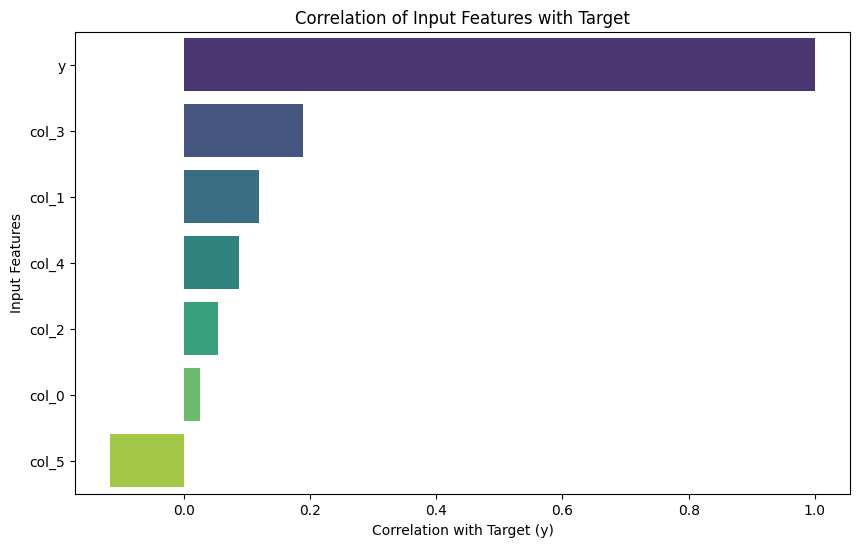

In [2]:
# Encode categorical variables
encoded_train_data = train_data.copy()
for col in encoded_train_data.columns:
    if encoded_train_data[col].dtype == 'object':
        encoded_train_data[col] = LabelEncoder().fit_transform(encoded_train_data[col])

# Compute correlation coefficients between input columns and target column
correlation_with_target = encoded_train_data.drop('ID', axis=1).corr()['y'].sort_values(ascending=False)

# Plot correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
plt.xlabel('Correlation with Target (y)')
plt.ylabel('Input Features')
plt.title('Correlation of Input Features with Target')
plt.show()

In [3]:
# Combine the training and test data for label encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Handling categorical variables using Label Encoding
label_encoders = {}
for col in combined_data.columns:
    if combined_data[col].dtype == 'object':
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col])
        label_encoders[col] = le

# Separate the combined data back into X_train and X_test
X_train = combined_data[:len(X_train)]
X_test = combined_data[len(X_train):]

# Print shapes of datasets and splits
print("Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print()

# Convert categorical labels to numeric values for classification
label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)

Shapes:
X_train shape: (6000, 6)
X_test shape: (4000, 6)



In [4]:
# Define Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, reg_alpha=0.2, reg_lambda=0.2),
    #"SVM": SVC(kernel='linear', class_weight='balanced', random_state=42),
    # Logistic Regression with L2 regularization (Ridge)
    "LogisticRegression": LogisticRegression(class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42),
    "GradientBoosting": GradientBoostingClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "NaiveBayes": GaussianNB(),
    "LightGBM": LGBMClassifier(reg_alpha=0.2, reg_lambda=0.2),
    "CatBoost": CatBoostClassifier(silent=True, depth=5, l2_leaf_reg=3)
}

# classifiers = {
#     "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "XGBoost": XGBClassifier(random_state=42),
#     #"SVM": SVC(kernel='linear', class_weight='balanced', random_state=42),
#     "LogisticRegression": LogisticRegression(class_weight='balanced', random_state=42),
#     "GradientBoosting": GradientBoostingClassifier(random_state=42),
#     "NaiveBayes": GaussianNB(),
#     "LightGBM": LGBMClassifier(),
#     "CatBoost": CatBoostClassifier(silent=True)
# }


# Initialize ensemble classifier, Voting Classifier that combines the predictions from multiple classifiers using soft voting
voting_clf = VotingClassifier(estimators=[('rf', classifiers['RandomForest']), 
                                           ('xgb', classifiers['XGBoost']), 
                                           #('svm', classifiers['SVM']), 
                                           ('lr', classifiers['LogisticRegression']), 
                                           ('gb', classifiers['GradientBoosting']), 
                                           ('nb', classifiers['NaiveBayes']), 
                                           ('lgbm', classifiers['LightGBM']), 
                                           ('catboost', classifiers['CatBoost'])], 
                               voting='soft')

# Define best model variables
best_score = 0
best_classifier = None
best_classifier_name = ""

# Iterate through classifiers # cross-validation with SMOTE(address class imbalance)
# evaluating each classifier's performance using accuracy scores
for clf_name, clf in classifiers.items():
    print(f"Evaluating {clf_name}...")
    for train_index, val_index in skf.split(X_train, y_train_encoded):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        # Address Class Imbalance using SMOTE to oversample the minority class for each fold separately
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # Split resampled training data into training and validation sets
        # allows to evaluate the model's performance on a separate validation set for each fold (to ensure the model generalizes well to unseen data)
        # X_train_split_resampled, X_val_split, y_train_split_resampled, y_val_split = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42)

        # Train the classifier on the training data
        # clf.fit(X_train_split_resampled, y_train_split_resampled)
        clf.fit(X_train_resampled, y_train_resampled)
        
        # Evaluate the classifier on the validation data
        # score = clf.score(X_val_split, y_val_split)
        
        # Evaluate the classifier based on validation fold(obtained from the cross-validation split) on the accuracy score
        # it ensures that the model is evaluated on all data points in the validation set across different folds
        score = clf.score(X_val_fold, y_val_fold)
        
        # Update the best classifier if the current one has a higher score
        if score > best_score:
            best_score = score
            best_classifier = clf
            best_classifier_name = clf_name
            
print(f"The best classifier is: {best_classifier_name}")

#Second SMOTE is applied outside the loop to oversample the entire training data before training the final model
#Ensures that the final model is trained on a balanced dataset (to ensure the model generalizes well to unseen data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")
print()

# Split resampled training data into training and validation sets for evaluation
X_train_split_resampled, X_val, y_train_split_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42)

# Train the best classifier on the full 80 percent of training data after resampling with SMOTE

best_classifier.fit(X_train_split_resampled, y_train_split_resampled)

print(f"X_train_split shape: {X_train_split_resampled.shape}")
print(f"y_train_split shape: {y_train_split_resampled.shape}")
print()
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Evaluating RandomForest...
Evaluating XGBoost...
Evaluating LogisticRegression...
Evaluating GradientBoosting...
Evaluating NaiveBayes...
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 27798, number of used features: 6
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1158
           1       1.00      1.00      1.00      1158
           2       0.99      1.00      0.99      1158
           3       0.99      1.00      1.00      1159
           4       1.00      0.99      1.00      1159
           5       1.00      1.00      1.00      1158

    accuracy                           1.00      6950
   macro avg       1.00      1.00      1.00      6950
weighted avg       1.00      1.00      1.00      6950



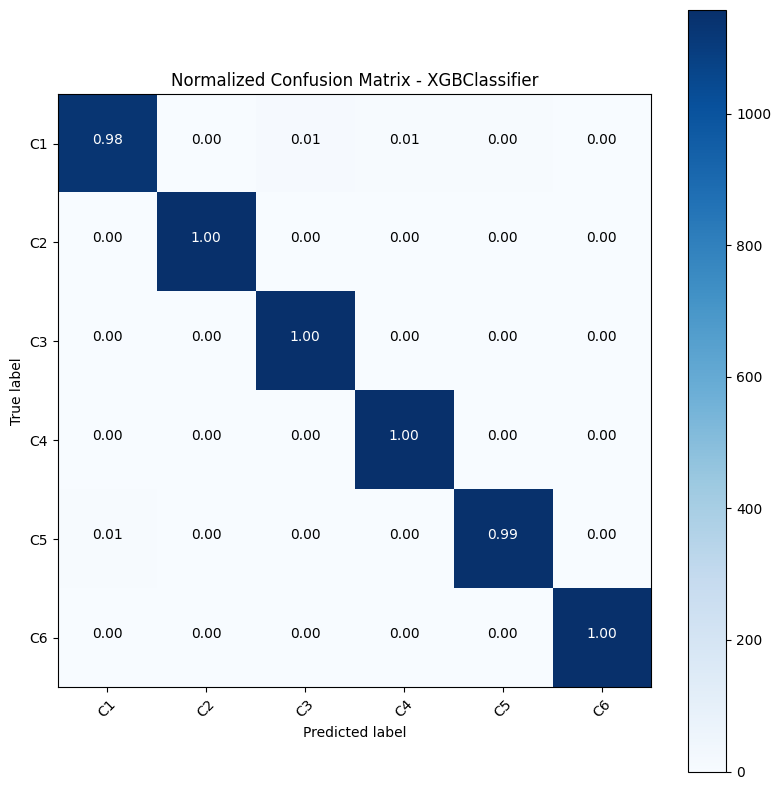

In [5]:
# Make predictions on the validation data
y_pred = best_classifier.predict(X_val)

# Generate classification report(precision, recall, and F1-score)
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=label_encoder_y.classes_, normalize=True, title=f'Normalized Confusion Matrix - {best_classifier.__class__.__name__}')
plt.show()


# Make predictions on the test data (test.csv)
test_predictions = best_classifier.predict(X_test)

# Convert encoded labels back to original categorical labels
predicted_labels = label_encoder_y.inverse_transform(test_predictions)

# Create a DataFrame with ID and predicted labels
predicted_df = pd.DataFrame({'ID': test_data['ID'], 'y': predicted_labels})
# predicted_df = pd.DataFrame({'ID': X_test.index, 'y': predicted_labels}) #index from 0

# Save the predictions to a CSV file
predicted_df.to_csv('predicted_labels.csv', index=False)


# Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(X_train, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

# Reset the index of testX
# testX = testX.reset_index(drop=True)

# Make predictions on the splitted 20 percent of actual training data (testX) from (train.csv)
testX_predictions = best_classifier.predict(testX)

# Convert encoded labels back to original categorical labels
predicted_labels = label_encoder_y.inverse_transform(testX_predictions)

# Create a DataFrame with ID and predicted labels for the splitted 20 percent data of train.csv
predicted_testX_df = pd.DataFrame({'ID': testX.index + 1, 'y': predicted_labels})  # Adding 1 to match original IDs

# Save the predictions for the splitted 20 percent data of train.csv to a CSV file
predicted_testX_df.to_csv('predicted_testX_labels.csv', index=False)

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree Classifier
#decision_tree.fit(X_train, y_train_encoded)

# Fit Decision Tree Classifier on the resampled training data
decision_tree.fit(X_train_split_resampled, y_train_split_resampled)

# Print the decision tree structure
tree_rules = decision_tree.tree_

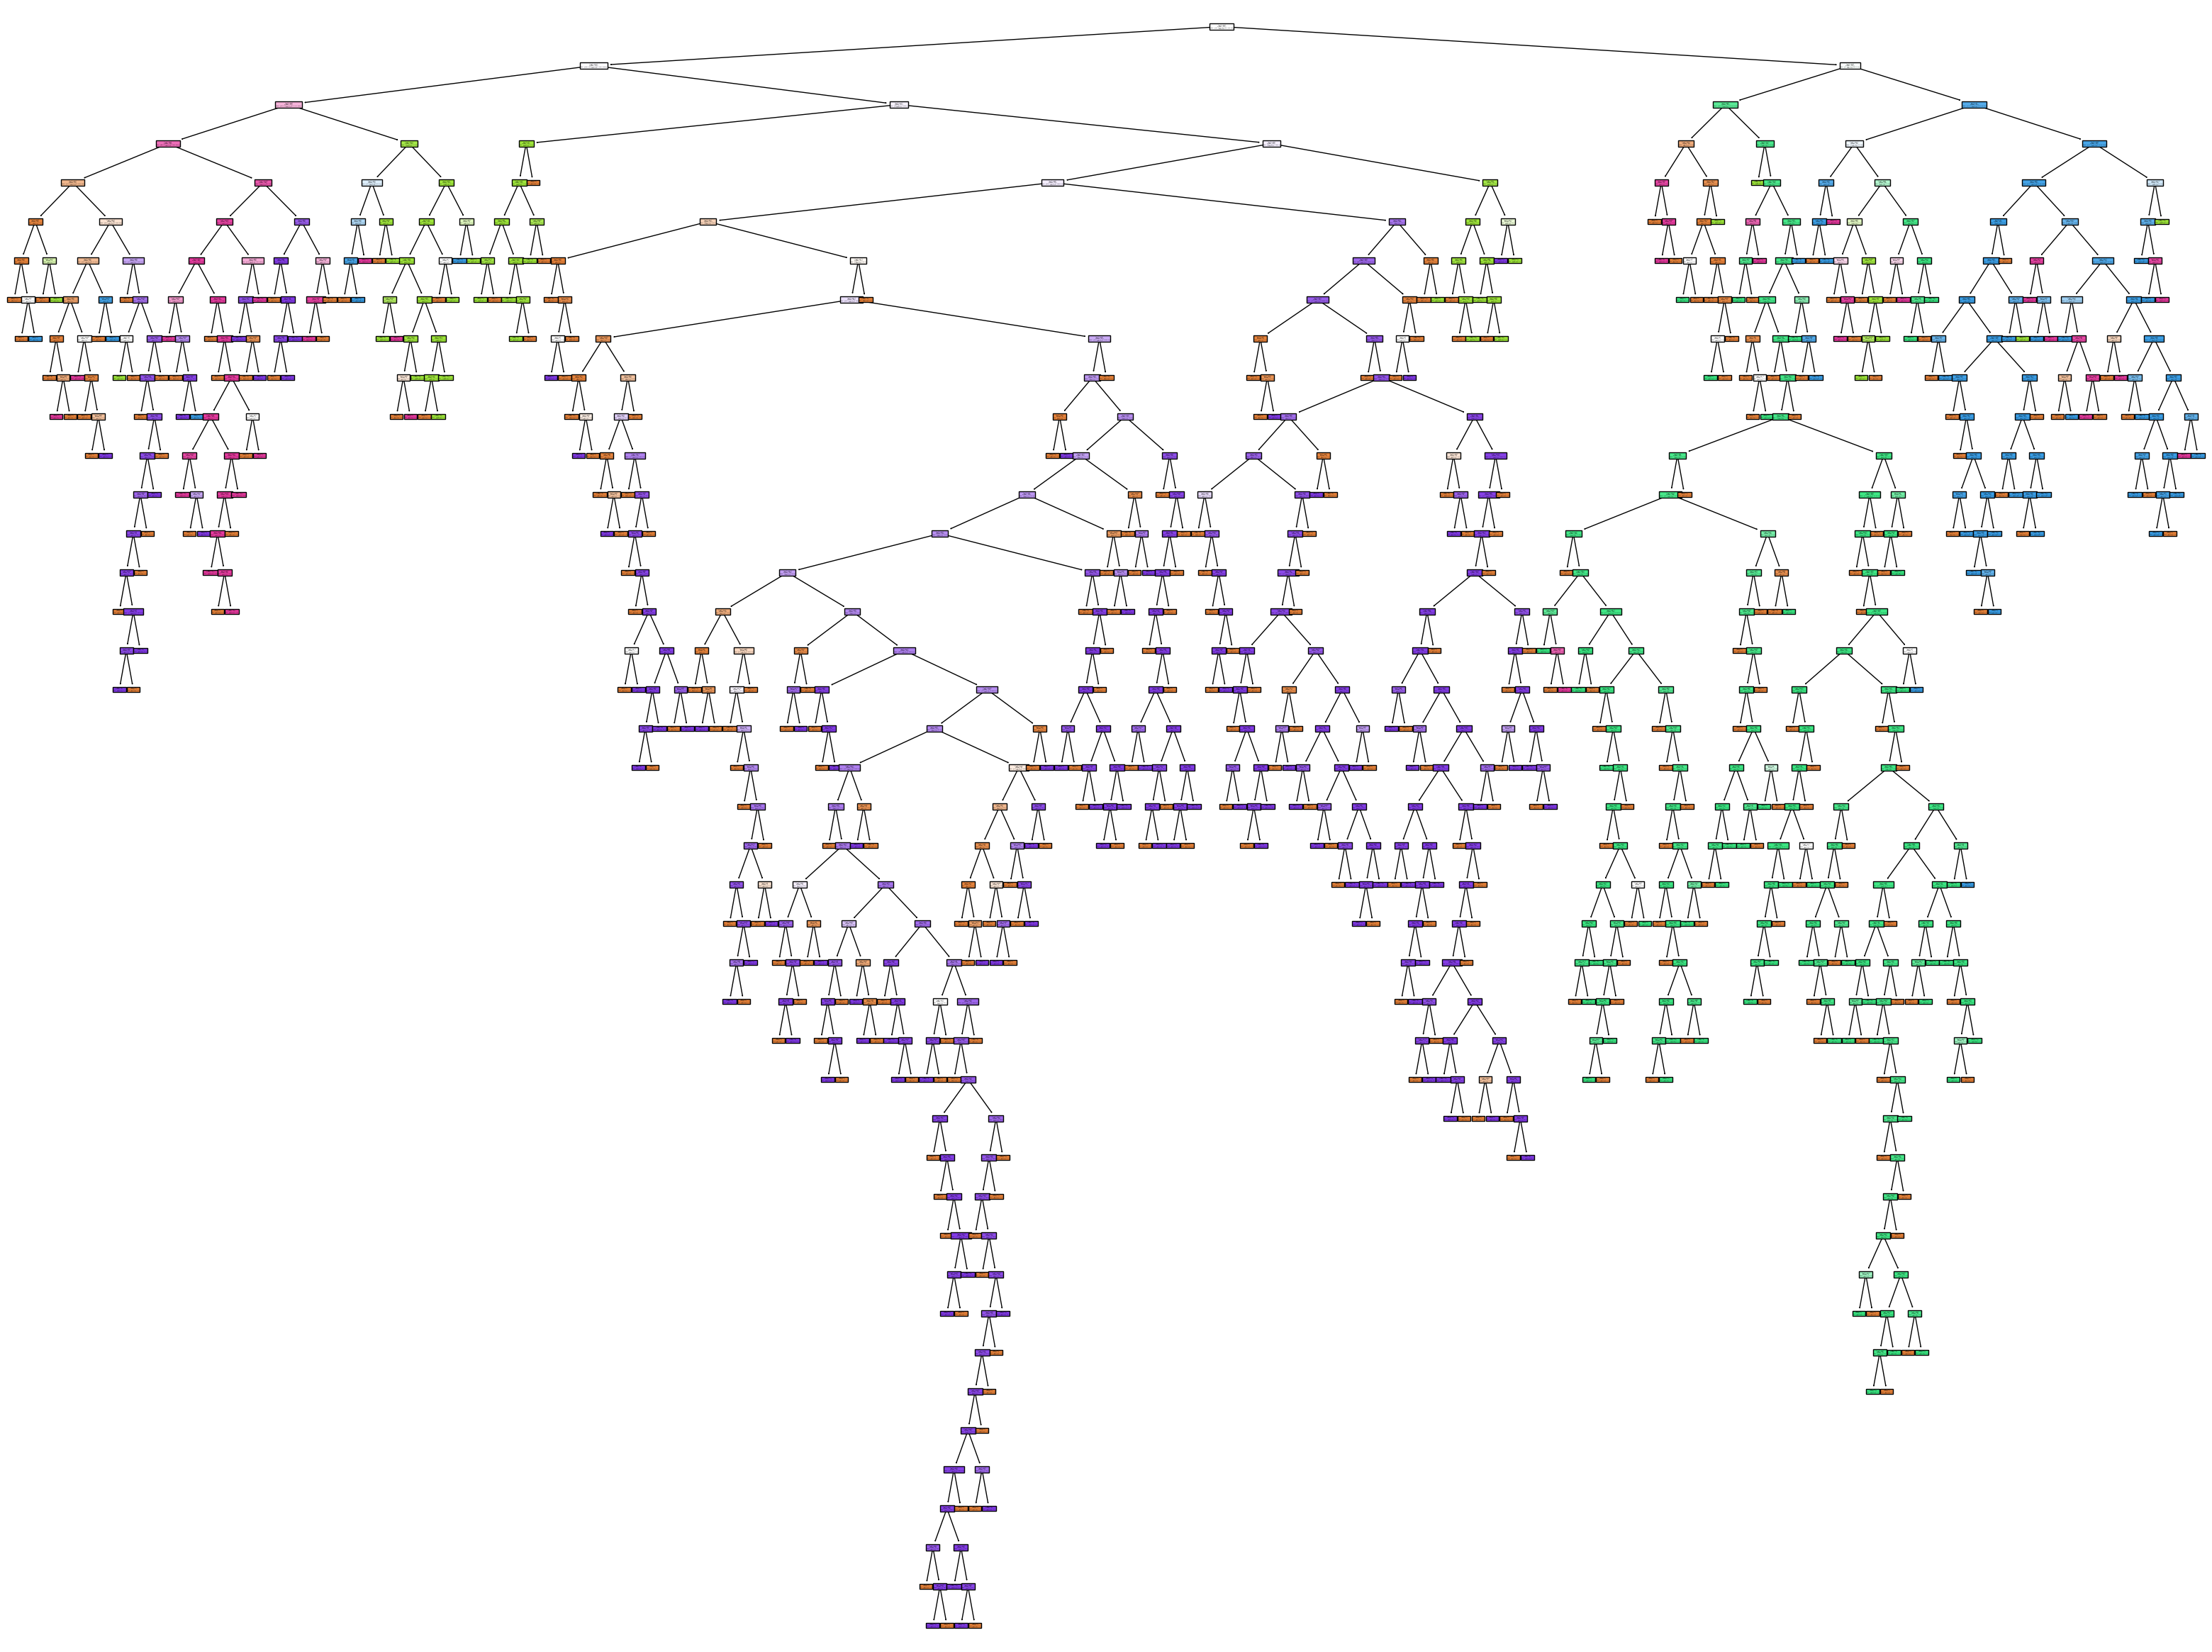

In [7]:
# Plot and save the decision tree logic
plt.figure(figsize=(40, 30)) 
#plot_tree(decision_tree, feature_names=X_train.columns, class_names=label_encoder_y.classes_, filled=True)

plot_tree(decision_tree, feature_names=X_train_split_resampled.columns, class_names=label_encoder_y.classes_, filled=True)
plt.savefig('decision_tree_plot.png')
plt.show()